# Classification without sampling methods

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
def load_csv_data(path:str):
    X_train = pd.read_csv(f'{path}/X_train.csv')
    X_test = pd.read_csv(f'{path}/X_test.csv')
    y_train = np.squeeze(np.array(pd.read_csv(f'{path}/y_train.csv')))
    y_test = np.squeeze(np.array(pd.read_csv(f'{path}/y_test.csv')))

    return (X_train,X_test,y_train,y_test)



In [3]:
X_train_cat,X_test_cat,y_train_cat,y_test_cat = load_csv_data('imbalanced_dataset_cat')
X_train_cont,X_test_cont,y_train_cont,y_test_cont = load_csv_data('imbalanced_dataset_cont')


## With nominals features:

In [5]:
def plot_pca(X_pca, y_train, title):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

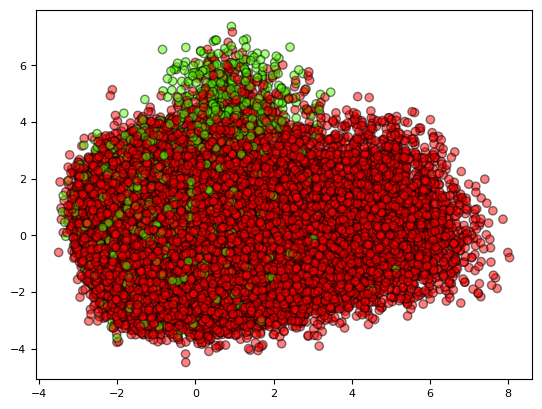

In [6]:
pca = PCA(n_components=2)
pca.fit(X_train_cat)
X_train_cat_pca = pca.transform(X_train_cat)
plot_pca(X_train_cat_pca, y_train_cat, f'Negatives: {57600} | Positives: {5436}')

In [6]:
from sklearn.model_selection import RandomizedSearchCV
# DECISION TREE
parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24,26,30,35,40,45,50,55,60,70,80,90,100,110,120,140]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = RandomizedSearchCV(
    dtc, 
    parameters,
    n_iter=500,
    scoring='f1_macro', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train_cat, y_train_cat)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
selected = clf.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
DecisionTreeClassifier(max_depth=100, min_samples_leaf=8, min_samples_split=60,
                       random_state=8)
{'min_samples_split': 60, 'min_samples_leaf': 8, 'max_depth': 100, 'criterion': 'gini'}
0.6779813910076872


In [7]:
y_train_cat.shape

(63036,)

In [6]:
# decision tree selected model
model = DecisionTreeClassifier(max_depth=100, min_samples_leaf=8, min_samples_split=60,
                       random_state=8)
y_pred = cross_val_predict(model, X_train_cat, y_train_cat, cv=5)
y_pred_proba = cross_val_predict(model, X_train_cat, y_train_cat, cv=5, method='predict_proba')

print(classification_report(y_train_cat, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     57600
           1       0.56      0.31      0.40      5436

    accuracy                           0.92     63036
   macro avg       0.75      0.64      0.68     63036
weighted avg       0.90      0.92      0.91     63036



In [7]:
feat_dec = {i:attr for attr,i in zip(X_train_cat.columns, range(len(list(X_train_cat.columns))))}
model = DecisionTreeClassifier(max_depth=16, min_samples_split=4, random_state=8)
model.fit(X_train_cat, y_train_cat)
feature_importance = [{'name': name, 'importance': imp} for name, imp in zip(X_train_cat.columns, model.feature_importances_)]
feature_importance = sorted(feature_importance, key= lambda x: x['importance'], reverse=True)
pd.DataFrame(feature_importance[:20])

,name,importance
0,speechiness,0.228718
1,comedy,0.056607
2,popularity,0.048383
3,danceability,0.047902
4,emo,0.047616
5,duration_ms,0.044920
6,acousticness,0.043320
7,valence,0.039992
8,energy,0.038378
9,loudness,0.035204


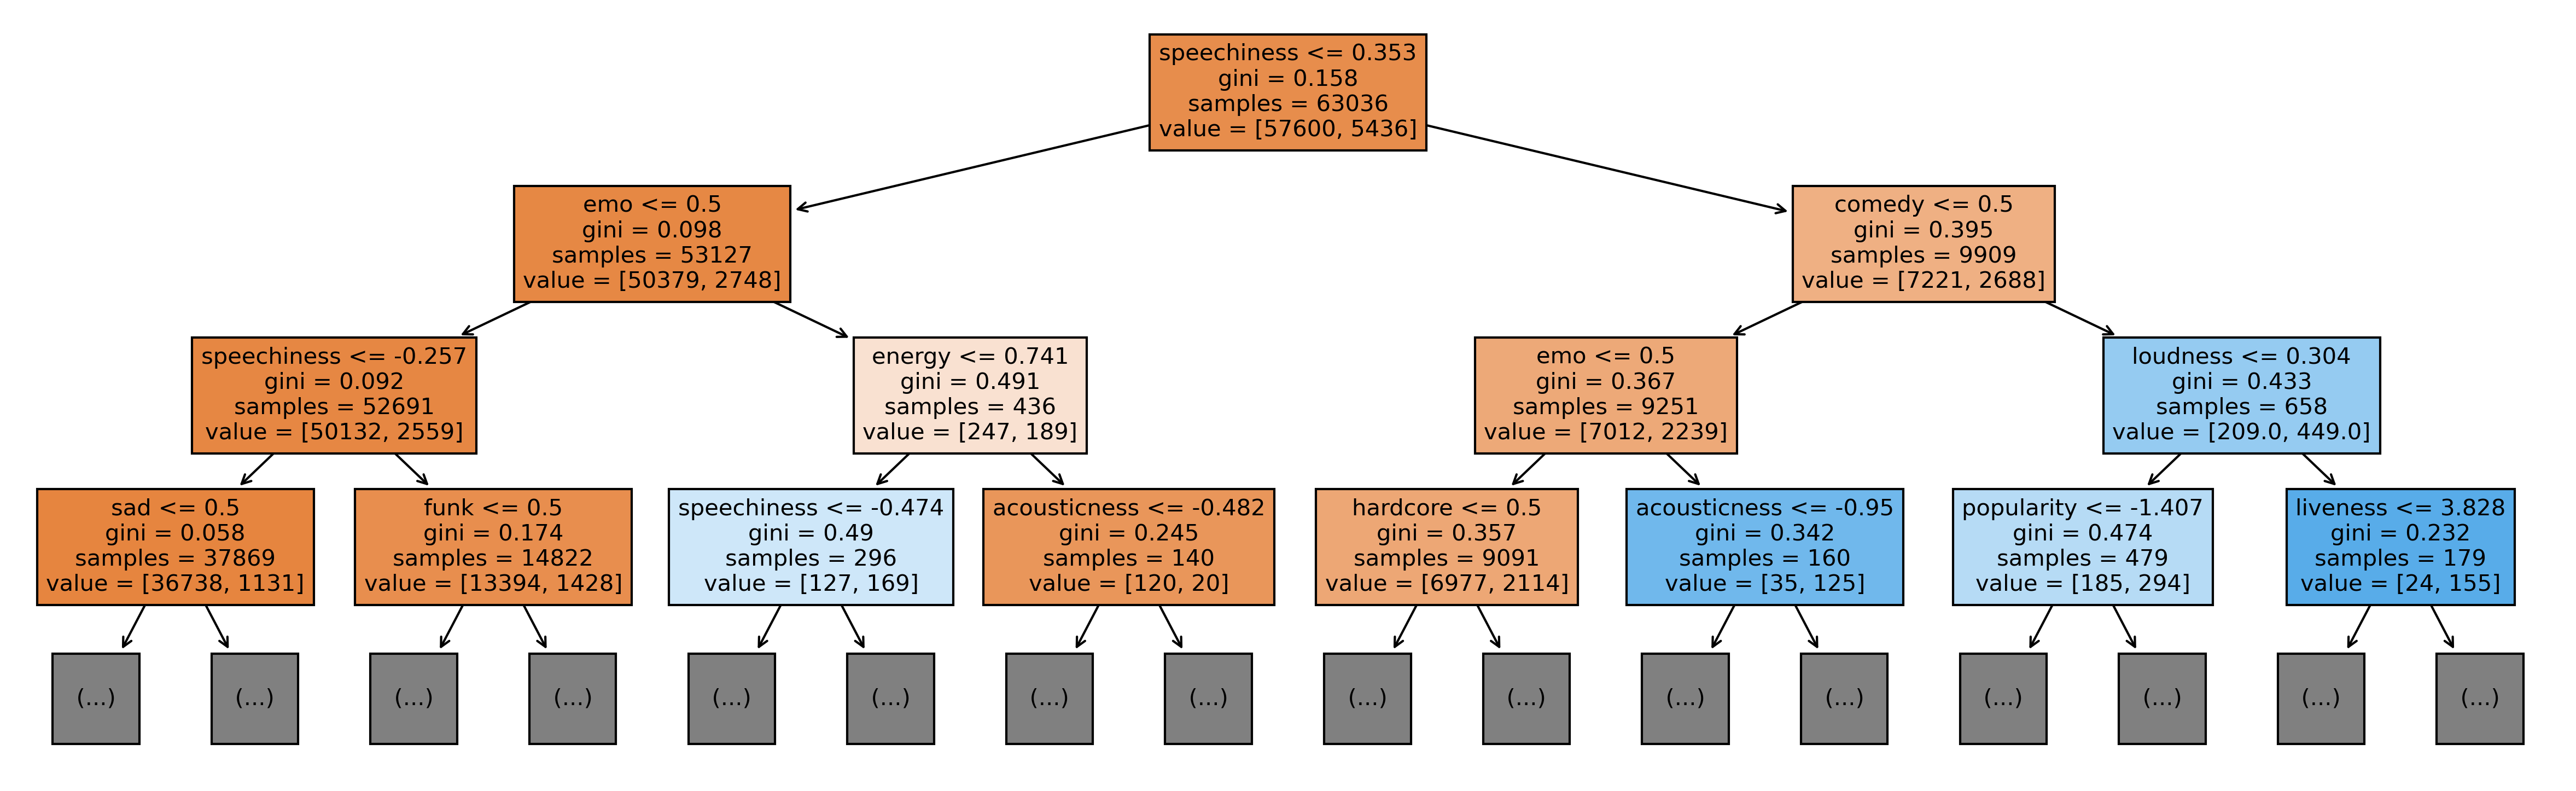

In [8]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 6), dpi=300)
plot_tree(model, feature_names=X_train_cat.columns, filled=True, max_depth=3, fontsize=10)
plt.show()

### Test

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     19201
           1       0.54      0.30      0.39      1812

    accuracy                           0.92     21013
   macro avg       0.74      0.64      0.67     21013
weighted avg       0.90      0.92      0.91     21013



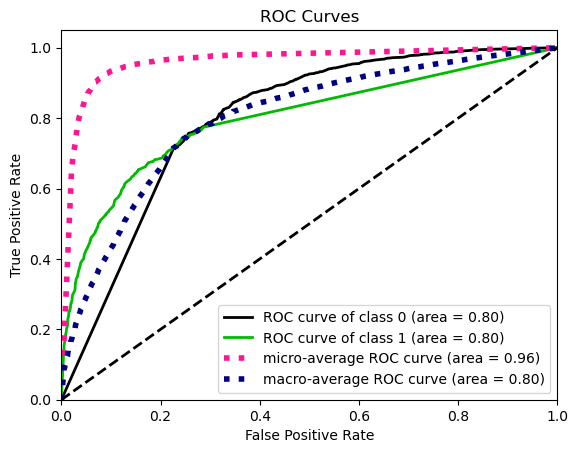

In [5]:
model = DecisionTreeClassifier(max_depth=100, min_samples_leaf=8, min_samples_split=60,
                       random_state=8)
model.fit(X_train_cat, y_train_cat)
y_pred = model.predict(X_test_cat)
y_pred_proba = model.predict_proba(X_test_cat)

print(classification_report(y_test_cat, y_pred))
plot_roc(y_test_cat, y_pred_proba)
plt.legend(loc='lower right',prop={'size': 10})
plt.show()

## With Continuos Features

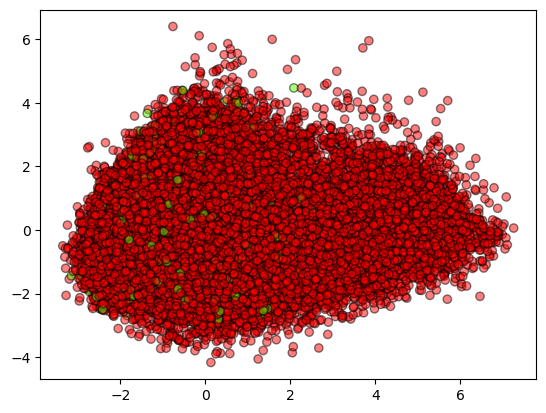

In [27]:
pca = PCA(n_components=2)
pca.fit(X_train_cont)
X_train_cont_pca = pca.transform(X_train_cont)
plot_pca(X_train_cont_pca, y_train_cat)

## Model Selection

In [28]:
parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24,26,30,35,40,45,50,55,60,70,80,90,100,110,120,140]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = RandomizedSearchCV(
    dtc, 
    parameters,
    n_iter=500,
    scoring='f1_macro', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(X_train_cont, y_train_cont)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
selected = clf.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
DecisionTreeClassifier(max_depth=16, min_samples_leaf=6, min_samples_split=6,
                       random_state=8)
{'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': 16, 'criterion': 'gini'}
0.5678913871926943


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57601
           1       0.24      0.12      0.16      1906

    accuracy                           0.96     59507
   macro avg       0.61      0.55      0.57     59507
weighted avg       0.95      0.96      0.95     59507



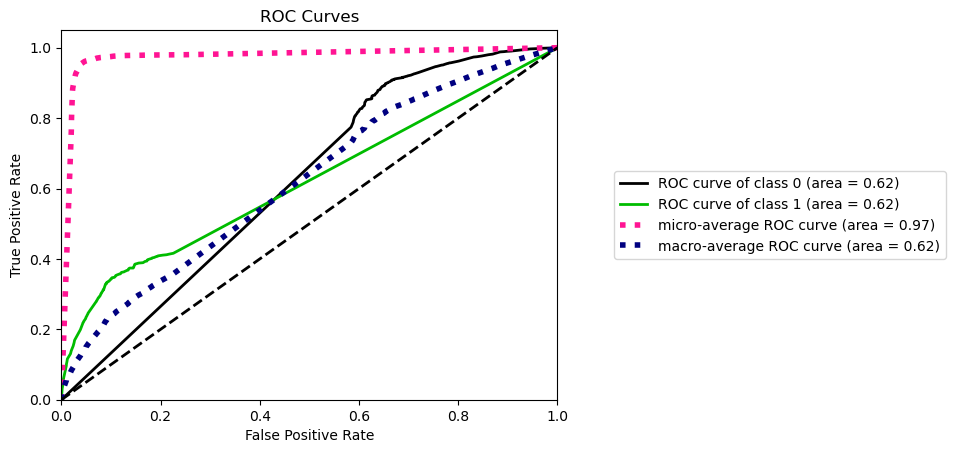

In [29]:
# decision tree selected model
model = DecisionTreeClassifier(max_depth=16, min_samples_leaf=6, min_samples_split=6,
                       random_state=8)
y_pred = cross_val_predict(model, X_train_cont, y_train_cont, cv=5)
y_pred_proba = cross_val_predict(model, X_train_cont, y_train_cont, cv=5, method='predict_proba')

print(classification_report(y_train_cont, y_pred))
plot_roc(y_train_cont, y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

## Test

In [30]:
model = DecisionTreeClassifier(max_depth=16, min_samples_leaf=6, min_samples_split=6,
                       random_state=8)
model.fit(X_train_cont, y_train_cont)
y_pred = model.predict(X_test_cont)

print(classification_report(y_test_cont, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19200
           1       0.24      0.11      0.15       636

    accuracy                           0.96     19836
   macro avg       0.60      0.55      0.57     19836
weighted avg       0.95      0.96      0.95     19836

